###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 1D viscoelastic SH modelling

After deriving the equations of motion for 1D wave propagation in viscoelastic SH media, we can now solve the problem using a staggered grid FD scheme. Furthermore, the anelastic coefficients of the Generalized Maxwell body (GMB) are optimized by a global Differential Evolution (DE) algorithm to achive a constant Q-spectrum. Finally, elastic and viscoelastic modelling results for a homogeneous model are compared.

## FD solution of 1D isotropic viscoelastic SH problem

As derived in the last lesson, we can describe the 1D viscoelastic SH problem by the partial differential equations:



The 2nd order space/time FD scheme on a staggered grid 

<img src="images/SG_1D_SH-Cart.png" width="50%">

using explicit time-stepping with the Leapfrog method to solve the 1D viscoelastic SH problem can be written as 

\begin{align}
\scriptsize 
\frac{v_y(i,n+1/2) - v_y(i,n-1/2)}{dt} &\scriptsize= \frac{1}{\rho}\biggl\{\biggl(\frac{\partial \sigma_{yx}}{\partial x}\biggr)^c(i,n) + f_y(i,n)\biggr\}, \notag\\
\scriptsize\frac{\sigma_{yx}(i+1/2,n+1) - \sigma_{yx}(i+1/2,n)}{dt} &\scriptsize= \mu_{x,u} \biggl(\frac{\partial v_{y}}{\partial x}\biggr)^c(i+1/2,n+1/2) - \sum_{l=1}^L Y_l\xi_l(i+1/2,n),\notag\\
\scriptsize \frac{\xi_l(i+1/2,n+1/2) - \xi_l(i+1/2,n-1/2)}{dt} &\scriptsize= \omega_l \biggl(\frac{\partial v_{y}}{\partial x}\biggr)^c(i+1/2,n+1/2) - \omega_l \xi_l(i+1/2,n-1/2)\notag
\end{align}

with the unrelaxed shear modulus 

\begin{equation}
\mu_u = \frac{\mu}{1-\sum_{l=1}^L Y_l}\notag
\end{equation}

and the harmonically averaged unrelaxed shear modulus

\begin{equation}
\mu_{x,u} = 2 \biggl(\frac{1}{\mu_u(i)}+\frac{1}{\mu_u(i+1)}\biggr)^{-1}\notag
\end{equation}

Notice that we have to evaluate the memory variables $\xi_l$ in the stress update at a full time step, which has to be estimated from the $\xi_l$-values at half-time steps by arithmetic averaging:

\begin{equation}
\xi_l(i+1/2,n) = \frac{\xi_l(i+1/2,n+1/2)+\xi_l(i+1/2,n-1/2)}{2}\notag
\end{equation}

### Initial and boundary conditions

Because we have analytical solutions for wave propagation in homogeneous elastic media, we should test our code implementation for a similar medium, by setting density $\rho$ and shear modulus $\mu$ to constant values $\rho_0,\; \mu_0$

\begin{align}
\rho(i) &= \rho_0 \notag \\
\mu(i) &= \mu_0 = \rho_0 V_{s0}^2\notag
\end{align}

at each spatial grid point $i = 0, 1, 2, ..., nx$ and staggered grid points $i+1/2$ in order to compare the numerical with the analytical solution. For a complete description of the problem we also have to define initial and boundary conditions. The **initial condition** is 

\begin{equation}
v_y(i,-1/2) = \sigma_{yx}(i+1/2,0) = \xi_{l}(i+1/2,-1/2) = 0, \nonumber
\end{equation}

so the modelling starts with zero particle velocity, shear stress and memory variable amplitudes at each spatial grid point. As **boundary conditions**, we assume 

\begin{align}
v_y(0,n) &= \sigma_{yx}(1/2,n) = \xi_{l}(1/2,n) = 0, \nonumber\\
v_y(nx,n) &= \sigma_{yx}(nx+1/2,n) = \xi_{l}(nx+1/2,n) = 0, \nonumber\\
\end{align}

for all full and staggered time steps n, n+1/2. This **Dirichlet boundary condition**, leads to artifical boundary reflections which would obviously not describe a homogeneous medium. For now, we simply extend the model, so that boundary reflections are not recorded at the receiver positions.

Let's implement it ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.optimize import differential_evolution

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

## Optimizing Yl coefficients

To achieve a constant Q-spectrum, we have to optimize the anelastic coefficients $Y_l$. This can be achieved by minimizing the objective function:

\begin{equation}
\chi(Y_l) = \int_{\omega_{min}}^{\omega_{max}} \biggl(Q^{-1}(Y_l,\omega) - Q^{-1}_{opt}\biggr)^2 d\omega\notag
\end{equation}

where $Q^{-1}_{opt}$ denotes the target constant inverse Q-value within the frequency range of the source wavelet and 

\begin{equation}
Q^{-1}(Y_l,\omega) = \sum_{l=1}^L Y_l \frac{\omega_l\omega}{\omega^2+\omega_l^2}\notag
\end{equation}

is an approximation of the GMB Q-spectrum for $Q>>1$ according to ([Blanch et al. 1995](https://library.seg.org/doi/abs/10.1190/1.1443744), [Bohlen 2002](https://www.sciencedirect.com/science/article/pii/S0098300402000067), [Yang et al. 2016](https://jean-virieux.obs.ujf-grenoble.fr/IMG/pdf/2016_yang_viscoelastic_final-3.pdf)). The objective function can be minimized using local or global optimization methods. In this case, we will use a global optimization [Differential Evolution (DE)](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) algorithm available from `SciPy Optimization` library.

In the following example, we want to solve the viscoelastic SH-problem by the (2,2)-FD algorithm defined above for a homogeneous model using 4 Maxwell bodies and target for a constant Q=20 value in a frequency band between 5 and 100 Hz:

In [3]:
# Define GMB models
# -----------------
Qopt = 20     # target Q-value
L = 4         # number of Maxwell bodies    
nfreq = 50    # number of frequencies to estimate Q-model

fmin = 5.     # minimum frequency 
fmax = 100.0  # maximum frequency

f = np.linspace(fmin,fmax,num=nfreq)  # calculate frequencies to estimate Q-model
w = 2 * np.pi * f                     # circular frequencies to estimate Q-model 

fl = np.linspace(fmin,fmax,num=L)  # calculate relaxation frequencies
wl = 2 * np.pi * fl                # circular relaxation frequencies 

Next, we define the objective function to optimize the $Y_l$ values ...

In [4]:
# Objective function to optimize Yl values
# ----------------------------------------
def obj_Yl(Yl):                   
    
    # Calculate Qs model based on GMB
    # -------------------------------
    Qinv_GMB = np.zeros(nfreq)
    Qinv_const = (1/Qopt) * np.ones(nfreq)
    
    for l in range (0,L):    
        Qinv_GMB += Yl[l] * (wl[l] * w) / (w**2+wl[l]**2)
    
    # Calculate objective function
    obj_Qinv = np.sum((Qinv_GMB - Qinv_const)**2)
    
    return obj_Qinv

A function to evaluate the Q-spectrum for given $Y_l$ values might be also useful ...

In [5]:
# Calculate Q-spectrum for given Yl parameters and circular relaxation frequencies
# --------------------------------------------------------------------------------
def calc_Q(Yl):            
    
    # Calculate Qs model based on GMB
    # -------------------------------
    Qinv_GMB = np.zeros(nfreq)    
    for l in range (0,L):    
        Qinv_GMB += Yl[l] * (wl[l] * w) / (w**2+wl[l]**2) 
    
    return f, Qinv_GMB

To optimize the $Y_l$ values, we define their bounds necessary for the DE-algorithm, minimize the objective function, store the resulting $Y_l$ values and plot the optimized Q-spectrum

  Final obj_Qinv =  7.651346890187525e-05
Yl =  [0.08706609 0.03667265 0.         0.0629249 ]
wl =  [ 31.41592654 230.38346126 429.35099599 628.31853072]


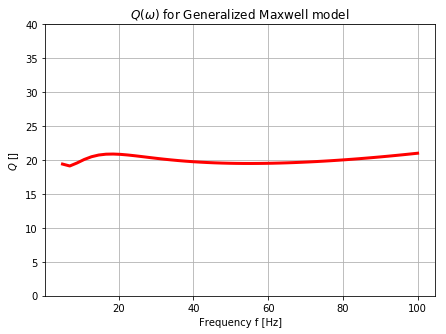

In [6]:
# Optimize dimensionless, anelastic coefficients Yl
# -------------------------------------------------

# Define bound constraints for DE algorithm
bounds = [(0.0, 1), (0.0, 1), (0.0, 1), (0.0, 1)]

# Optimize Q-model by Differential Evolution
DE_result = differential_evolution(obj_Yl, bounds)
print('  Final obj_Qinv = ', DE_result.fun)

# Calculate optimum Q model
f, Qinv_GMB = calc_Q(DE_result.x)

# Store and display optimized Yl, wl values
Yl = np.zeros(L)
Yl = DE_result.x
print('Yl = ', Yl)
print('wl = ', wl)

# Calculate Q(omega)
Q = 1 / Qinv_GMB

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Q, 'r-',lw=3,label="Generalized Maxwell model") 
plt.title(r'$Q(\omega)$ for Generalized Maxwell model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$Q$ []')
plt.ylim(0,2*Qopt)
plt.grid()
plt.show()

As usual, we define the modelling parameters ...

In [7]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
tmax = 0.502   # maximum recording time of the seismogram (s)

vs0  = 580.   # S-wave speed in medium (m/s)
rho0 = 1000.  # Density in medium (kg/m^3)

# acquisition geometry
xr = 330.0 # x-receiver position (m)

xsrc = 250.0 # x-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

Next, we first test the elastic part of the 1D SH code and compare it with the analytical solution and finally run the viscoelastic SH code.

## Comparison of 2D finite difference with analytical solution for homogeneous Vs model

In a previous [exercise](https://danielkoehnsite.files.wordpress.com/2018/04/ex_02_tew21.pdf) you proved that the analytical solutions for the homogeneous 1D acoustic and 1D elastic SH problem, beside a density factor $1/\rho_0$, are actual identical . In the function below we solve the homogeneous 1D SH problem by centered 2nd order spatial/temporal difference operators and compare the numerical results with the analytical solution: 

\begin{equation}
u_{y,analy}(x,t) = G_{1D} * S \nonumber 
\end{equation}

with the 1D Green's function:

\begin{equation}
G_{1D}(x,t) = \dfrac{1}{2 \rho_0 V_{s0}}H\biggl((t-t_s)-\dfrac{|r|}{V_{s0}}\biggr), \nonumber 
\end{equation}

where $H$ denotes the Heaviside function, $r = \sqrt{(x-x_s)^2}$ the source-receiver distance (offset) and $S$ the source wavelet. Keep in mind that the stress-velocity code computes the **particle velocities** $\mathbf{v_{y,analy}}$, while the analytical solution is expressed in terms of the **displacement** $\mathbf{u_{y,analy}}$. Therefore, we have to take the first derivative of the analytical solution, before comparing the numerical with the analytical solution:

\begin{equation}
v_{y,analy}(x,t) = \frac{\partial u_{y,analy}}{\partial t} \nonumber 
\end{equation}

To implement the 2D SH code, we first introduce functions to update the particle velocity $v_y$ ...

In [8]:
# Particle velocity vy update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vy, syx, dx, dt, nx, rho):
    
    for i in range(1, nx - 1):
            
        # Calculate spatial derivatives            
        syx_x = (syx[i] - syx[i - 1]) / dx

        # Update particle velocities
        vy[i] = vy[i] + (dt/rho[i]) * syx_x                
                    
    return vy

... update the shear stress component $\sigma_{yx}$ for the elastic medium ...

In [9]:
# Shear stress syx updates (elastic)
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vy, syx, dx, dt, nx, mux):
    
    for i in range(1, nx - 1):
            
        # Calculate spatial derivatives            
        vy_x = (vy[i + 1] - vy[i]) / dx

        # Update shear stress
        syx[i] = syx[i] + dt * mux[i] * vy_x
                    
    return syx

... and a function for the shear stress update $\sigma_{yx}$ for the viscoelastic case ...

In [10]:
# Shear stress syx updates (viscoelastic)
# ---------------------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress_visc(vy, syx, xi, Yl, wl, L, dx, dt, nx, mux):
    
    for i in range(1, nx - 1):
            
        # Calculate spatial derivatives            
        vy_x = (vy[i + 1] - vy[i]) / dx        
        
        # Calculate sum over memory variables
        xi_sum = 0.0
        for l in range(0, L):
            xi_sum += Yl[l] * xi[i,l]
        
        # Update shear stress 
        # Note that the factor 0.5 in front of the memory variables sum 
        # is due to the arithmetic averaging of the xi variables at 
        # the staggered time steps
        syx[i] = syx[i] + dt * mux[i] * (vy_x - 0.5 * xi_sum)
        
        # Update memory variables
        xi_sum = 0.0
        for l in range(0, L):
            xi[i,l] += dt * wl[l] * (vy_x - xi[i,l])
            
            # After xi update calculate new xi_sum ...
            xi_sum += Yl[l] * xi[i,l]
        
        # ... and finish stress update
        syx[i] = syx[i] - dt * mux[i] * xi_sum
        
    return syx, xi

... and harmonically averaging the (unrelaxed) shear modulus ...

In [11]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nx, mux):
    
    for i in range(1, nx - 1):
            
        # Calculate harmonic averages of shear moduli        
        mux[i] = 2 / (1 / mu[i + 1] + 1 / mu[i])
            
    return mux

Finally, we can assemble the main FD code ...

In [12]:
# 2D SH viscoelastic wave propagation (Finite Difference Solution) 
# ----------------------------------------------------------------
def FD_1D_visc_SH_JIT(dt,dx,f0,xsrc,Yl,wl,L,mode):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)    
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G        = time * 0.
    vy_analy = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)
    
    # calculate source-receiver distance
    r = np.sqrt((x[ir] - x[isrc])**2)
    
    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - r / vs0) >= 0:
            G[it] = 1. / (2 * rho0 * vs0)
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    
    # compute vy_analy from uy_analy
    for i in range(1, nt - 1):
        vy_analy[i] = (Gc[i+1] - Gc[i-1]) / (2.0 * dt)           
    
    # Initialize empty wavefield arrays
    # ---------------------------------
    vy    = np.zeros(nx) # particle velocity vy
    syx   = np.zeros(nx) # shear stress syx     

    # Initialize model (assume homogeneous model)
    # -------------------------------------------    
    vs    = np.zeros(nx)
    vs    = vs + vs0      # initialize wave velocity in model
    
    rho   = np.zeros(nx)
    rho   = rho + rho0    # initialize wave velocity in model
    
    # calculate shear modulus
    # -----------------------
    mu    = np.zeros(nx)
    mu    = rho * vs ** 2 
    
    # Estimate unrelaxed shear modulus in viscoelastic case
    # -----------------------------------------------------
    if(mode=='visc'):
        mu1 = mu / (1 - np.sum(Yl))
    
    # harmonic average of shear moduli
    # --------------------------------
    if(mode=='elast'):
        mux   = mu # initialize harmonic average mux
    
    if(mode=='visc'):
        mux   = mu1 # initialize harmonic average mux 
    
    mux = shear_avg(mu, nx, mux)
    
    # Initialize memory variables
    # ---------------------------
    if(mode=='visc'):
        xi = np.zeros((nx,L))
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Time looping
    # ------------
    for it in range(nt):
    
        # Update particle velocity vy
        # ---------------------------
        vy = update_vel(vy, syx, dx, dt, nx, rho)

        # Add Source Term at isrc
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vy[isrc] = vy[isrc] + (dt * src[it] / (rho[isrc] * dx))
        
        # Update shear stress syx, syz
        # ----------------------------
        if(mode=='elast'):
            syx = update_stress(vy, syx, dx, dt, nx, mux)                
            
        if(mode=='visc'):
            syx, xi = update_stress_visc(vy, syx, xi, Yl, wl, L, dx, dt, nx, mux)                           
            
        # Output of Seismogram
        # -----------------
        seis[it] = vy[ir]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    
    if(mode=='elast'):
        label = "Elastic FD solution"
        
    if(mode=='visc'):
        label = "Viscoelastic FD solution (Q = " + str(Qopt) + ")"    
    
    plt.plot(time, seis, 'b-',lw=3,label=label) # plot FD seismogram
    Analy_seis = plt.plot(time,vy_analy,'r--',lw=3,label="Elastic analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

... run the elastic FD code and compare the result with the analytical solution:

nx =  500
nt =  502


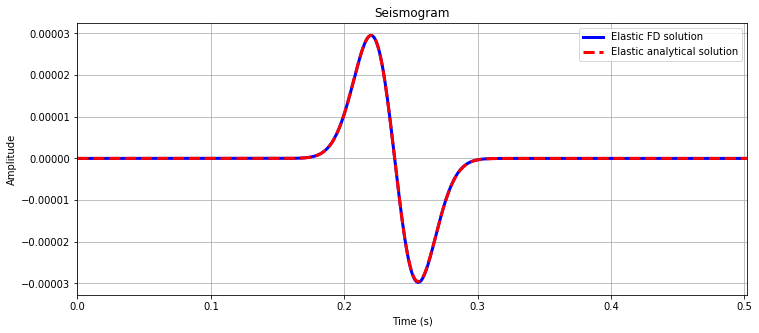

CPU times: user 384 ms, sys: 4 ms, total: 388 ms
Wall time: 388 ms


In [13]:
%%time
# FD modelling of homogeneous elastic medium
# ------------------------------------------
dx   = 1.0   # grid point distance in x-direction (m)
dt = 0.001   # time step (s)

FD_1D_visc_SH_JIT(dt,dx,f0,xsrc,Yl,wl,L,'elast')

Finally, we run the viscoelastic modelling run and compare it with the elastic analytical solution:

nx =  500
nt =  502


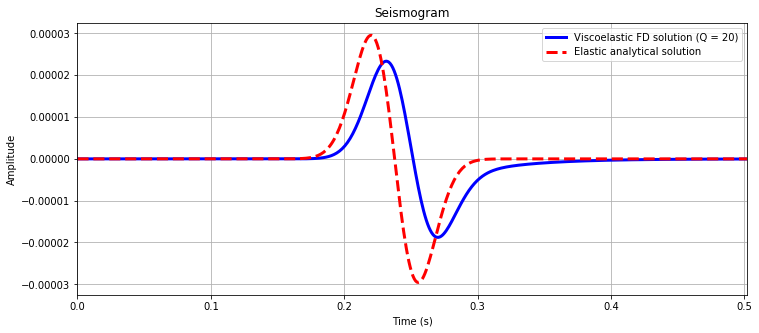

CPU times: user 292 ms, sys: 8 ms, total: 300 ms
Wall time: 295 ms


In [14]:
%%time
# FD modelling of homogeneous viscoelastic medium
# -----------------------------------------------
dx   = 1.0   # grid point distance in x-direction (m)
dt = 0.001   # time step (s)

FD_1D_visc_SH_JIT(dt,dx,f0,xsrc,Yl,wl,L,'visc')

## What we learned:

* How to solve the 1D viscoelastic SH problem by a staggered grid finite-difference approach
* Optimize the anelastic coefficients $Y_l$ by the global optimization Differential Evolution algorithm to achieve a constant Q-spectrum
* Compared the effect of intrinsic damping for $Q=20$ to the elastic analytical solution